# Notebook reviewing the unbalanced vynil disk

This notebook reviews the problem of the unbalanced vynil disk, a simple linear system with a non-linear deviation due to an imbalance in the disk manufacturing, causing it to spin unevenly when put in motion. The goal is to design a controller capable of handling the problem, with the long-term goal being to create c-code for the issue. (NOTE: All parameters are estimates.)

In [19]:
import matplotlib.pyplot as plt #matlplotlip for plotting
import numpy as np              #numpy for numerical operations
from models.VinylDynamics import UnbalancedVinyl #importing the UnbalancedVinyl class
from models.filter import notchFilter

# Explanation
The model below contains the _UnbalancedVinyl_ class, which contains the dynamics of the plant.

The solution can be called using _UnbalancedVinyl().solve_equations_, which employs scipy.integrate, to generate a solution.
You can also define a controller function _u(error,theta,dtheta)_

Look at the example below for more information

In [20]:
#parsing parameter values and the controller function to the class
m = 0.15 #kg, estimate of the mass of a vinyl disk
J = 1/2*(m)*(0.305)**2 # moment of inertia of a flat disk
m_com = m*0.1 #virtual mass of the center of mass
g = 9.81    # Gravitational acceleration (m/s^2)
l = 0.05     # Displacement of the C.O.M. of the vinyl
k = 0       # Spring constant (no physical interpretation) (1/s^2)
d = 0.15    # Linear drag coefficient (1/s)                (non-linear to be added) 
x0 = [1, 1] # Initial condition ([rad,rad/s])
fs = 1000    # sampling frequency (Hz)

In [47]:
## Defining controllers as a function
## PID
K_p = 5e1; K_d = 1e-1
def PID_controller(error, th, dth):
    input = K_p*error - K_d * dth
    return input

## Notch filter
f_c = 0.555; Q = -8e0;
notch = notchFilter(f_c,Q,fs)

## Adding both controllers
def controller_total(error, th, dth):
    return notch.increment(PID_controller(error, th, dth))

## Defining reference signal, in terms of desired attained theta
def constant_dtheta(t):
    rpm = 33.3
    theta_desired = (rpm/60*2*np.pi)*t #converting rpm to the correct rad/s
    return theta_desired
#Generating a solution using the solve_equations object
simulation_length = 10 #simulation time in seconds
solver_steps = fs*simulation_length
unb_vinyl = UnbalancedVinyl(J=J,m=m,g=g, l=l, k=k, d=d, x0=x0, fs=fs, controller = controller_total, reference = constant_dtheta)
sol, u_past = unb_vinyl.solve_equations(t_len=simulation_length, solver_steps = int(solver_steps))

controller is applied
reference is changed


(1.0, 10.0)

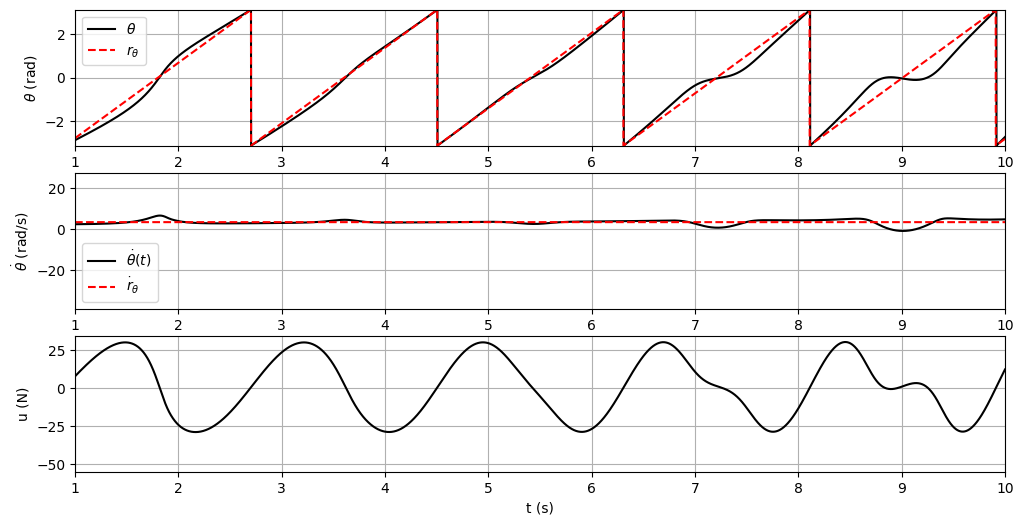

In [48]:
truncate_plot = True ## OPTIONAL: Bounding theta and theta_ref between [-pi, pi] in the plot
t_start = 1
t = sol.t
if truncate_plot:
    plot_theta = ((sol.y[0,:] + np.pi) % (2 * np.pi)) - np.pi
    plot_reference = ((constant_dtheta(sol.t) + np.pi) % (2 * np.pi)) - np.pi
    limits = [-np.pi,np.pi]
else:
    plot_theta = sol.y[0,:]
    plot_reference = constant_dtheta(sol.t)
    limits = [None,None]
reference_dt = np.divide(constant_dtheta(sol.t),sol.t+1e-16) #adding a miniscule value to prevent the divison going wack at t=0

## Plotting results ##
plt.figure(figsize=(12, 6))
## Subplot 1: the angle (normalized to ticks)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(sol.t, plot_theta,label=r'$\theta$',color='black')
ax1.plot(sol.t, plot_reference,label=r'$r_{\theta}$',color='red',linestyle='--')
ax1.set_xlim(t_start,simulation_length)

#plot settings first subplot
ax1.set_ylim(limits)
ax1.set_ylabel(r"$\theta$ (rad)")
ax1.grid('on')
ax1.legend(loc='best');

## Subplot 2: angular velocity
ax2 = plt.subplot(3, 1, 2)
ax2.plot(sol.t, sol.y[1,:],label=r'$\dot{\theta}(t)$',color='black')
ax2.plot(sol.t[1:], reference_dt[1:], label=r'$\dot{r}_{\theta}$',color='red',linestyle='--')

#plot settings second subplot
ax2.set_xlabel('t (s)')
ax2.set_ylabel(r"$\dot{\theta}$ (rad/s)")
ax2.grid('on')
ax2.legend();
ax2.set_xlim(t_start,simulation_length)

## Subplot 3: inputs
ax3 = plt.subplot(3, 1, 3)
ax3.plot(u_past[:,0], u_past[:,1], color='black')

#plot settings second subplot
ax3.set_xlabel('t (s)')
ax3.set_ylabel(r"u (N)")
ax3.grid('on')
ax3.set_xlim(t_start,simulation_length)

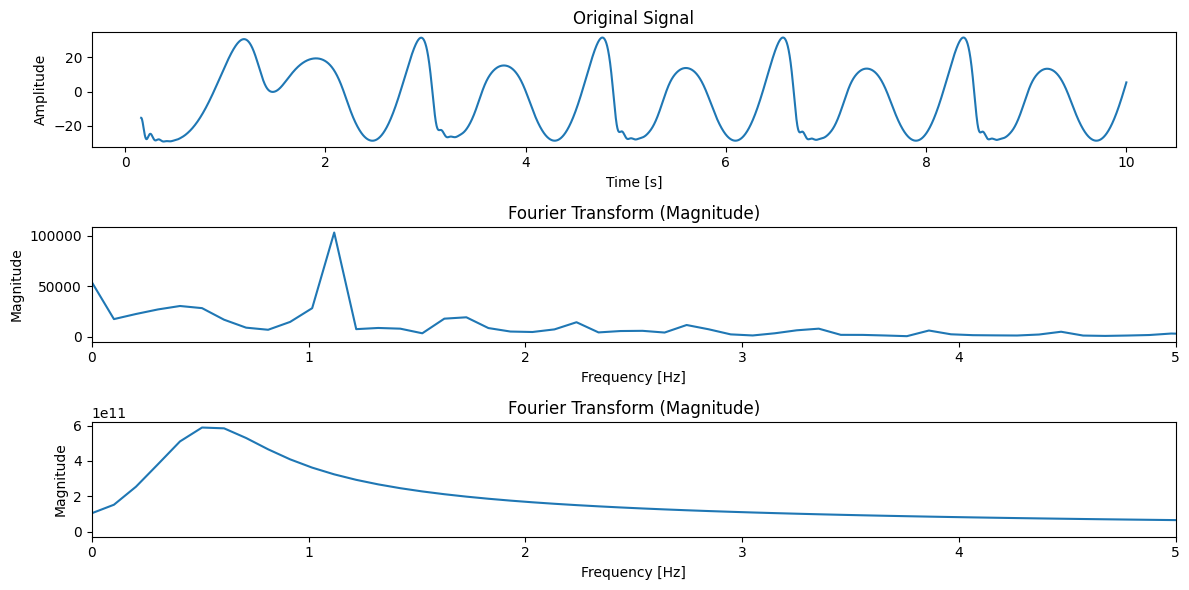

In [44]:
u_cut = u_past[163:,1]
t_u = u_past[163:,0]

u_filt = [notch.increment(i) for i in u_cut]
# Compute FFT
U = np.fft.fft(u_cut)
U_f = np.fft.fft(u_filt)
# Compute frequency bins
frequencies = np.fft.fftfreq(len(t_u), d=(t_u[1] - t_u[0]))

# Take only the positive frequencies
positive_freqs = frequencies[:len(frequencies)//2]
U_magnitude = np.abs(U[:len(U)//2])
U_f_magnitude = np.abs(U_f[:len(U)//2])

# Plotting the signal and its Fourier Transform
plt.figure(figsize=(12, 6))

# Plot original signal
plt.subplot(3, 1, 1)
plt.plot(t_u, u_cut)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot Fourier Transform (magnitude)
plt.subplot(3, 1, 2)
plt.plot(positive_freqs, U_magnitude)
plt.title('Fourier Transform (Magnitude)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,5)


# Plot Fourier Transform (magnitude)
plt.subplot(3, 1, 3)
plt.plot(positive_freqs, U_f_magnitude)
plt.title('Fourier Transform (Magnitude)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,5)
plt.tight_layout()
plt.show()

In [24]:
positive_freqs[np.where(U_magnitude==np.max(U_magnitude))]

array([0.30487805])